# 2 Многоклассовая классификация

## 1 Загрузка бибилиотек

In [2]:
import os

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import SVG
from tqdm import tqdm

from torch.utils.data import Dataset, DataLoader
import torchvision
from PIL import Image

import random
import torch

import copy

import albumentations as A
from albumentations import CropNonEmptyMaskIfExists
from typing import List, Optional, Tuple

import time
from tqdm import tqdm

from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, accuracy_score

## 2 Загрузка данных

In [3]:
import os
notebook_path = os.path.abspath("2st-nb-multi-class.ipynb")

In [4]:
# Подключим gpu
os.environ['CUDA_VISIBLE_DEVICES'] = '0' # gpu №1
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Тренировочные данные
train_df = pd.read_csv(os.path.join(os.path.dirname(notebook_path), 'train.csv'))

# Тренировочные данные разбитые по фолдам
folds_ids = pd.read_csv(os.path.join(os.path.dirname(notebook_path), 'full_train_df_folds.csv'))

In [5]:
# Номер фолда для валидации
NUM_FOLD = 0

In [6]:
# Разделим даннные на тренировочные (4 фолда) и валидационные (1 фолд)
train_files = folds_ids.loc[folds_ids.stratifiedkfold != NUM_FOLD, 'ImageId'].values
valid_files = folds_ids.loc[folds_ids.stratifiedkfold == NUM_FOLD, 'ImageId'].values

train_files.shape, valid_files.shape

((10054,), (2514,))

## 3 Датасет для тренировочных данных

Переменные величины:

In [7]:
# Базовая директория изображений
BASE_DIR = os.path.join(os.path.dirname(notebook_path), 'train_images')

# Размер изображения на входе
IN_DIM = (256, 1600)

# Число каналов маски (4 класса)
MASK_CHANELS = 4

Обработаем маску:

In [9]:
# Определим маску для 12-го индекса
mask_df = train_df[train_df['ImageId'] == train_files[3]]
rles = mask_df['EncodedPixels'].values
class_ids = mask_df['ClassId'].values

display(mask_df)
print(f'Класс дефекта: {class_ids}')

,ImageId,ClassId,EncodedPixels
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...


Класс дефекта: [3]


In [10]:
# Преобразуем строковые rle (run-length encoding) описания масок в формат изображений
def rle2mask(rle, input_shape):
    # Ширина и высота из входной формы
    width, height = input_shape[:2]

    # Пустой массив для маски
    mask = np.zeros( width*height ).astype(np.uint8)

    # rle стока в массив чисел
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    # Заполненим маски значениями 1 в указанных участках
    current_position = 0
    for index, start in enumerate(starts):
        mask[int(start):int(start+lengths[index])] = 1
        current_position += lengths[index]

    return mask.reshape(height, width).T

# Многослойные маски из списка rle строк
def build_masks(rles, class_ids, input_shape, num_classes):
    masks = np.zeros((*input_shape, num_classes), dtype=np.uint8)

    # Преобразование каждой строки rle в маску и добавление в массив масок
    for rle, class_id in zip(rles, class_ids):
        if isinstance(rle, str):
            masks[:, :, class_id - 1] = rle2mask(rle, input_shape)

    return masks

In [11]:
# Массив многослойных масок (в случае с несколькими классами) из списка rle строк
mask = build_masks(rles, class_ids, input_shape=IN_DIM, num_classes=MASK_CHANELS)
mask = np.asarray(mask, np.uint8)

mask.shape

(256, 1600, 4)

In [12]:
# Отобразим полученные маски
def display_masks(masks):
    fig, axes = plt.subplots(1, masks.shape[2], figsize=(17, 10))

    for i in range(masks.shape[2]):
        ax = axes[i]
        ax.imshow(masks[:, :, i], cmap='gray')
        ax.set_title(f'Канал маски {i + 1}')
        ax.axis('off')

    plt.show()

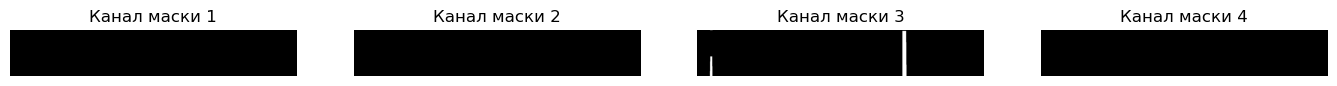

In [13]:
display_masks(mask)

Аугментация маски и изображения. Препроцессинг. Перевод в тензор:

In [14]:
# Полные пути до каждого изображения
images_path = [os.path.join(BASE_DIR, image_id) for image_id in train_files]

In [15]:
# Откроем одно изображение
image = cv2.imread(images_path[12], -1)
image.shape

(256, 1600, 3)

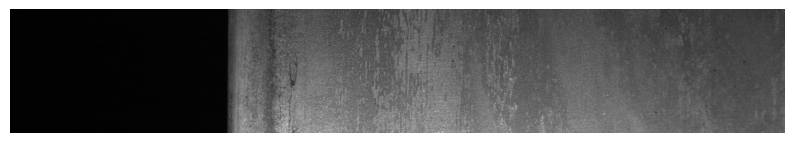

In [16]:
# Отобразим изображение
def display_image(img):
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

display_image(image)

In [17]:
# Композиция аугментаций изображений
def get_training_augmentation_crop_image():
    train_transform = [

        # Отразим горизонтально / вериткально
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),

        # Повернем, добавим искажения
        A.Rotate(limit=3, p=0.5),
        A.OpticalDistortion(p=0.2),

        # Выберем одно из следующих действий
        A.OneOf([

            # Кроп, если маска непустая (256x320) или случайный кроп
            # (может кропнуть участок где нет маскированных пикселей)
            CropNonEmptyMaskIfExists(256, 320, p=0.3),
            A.RandomCrop(256, 320, p=0.7),
        ], p=1.0),

        # Дополнение изображения, если необходимо, до размеров (256x320),
        # заполняя границы константным значением 0
        A.PadIfNeeded(min_height=256, min_width=320,
                      border_mode=cv2.BORDER_CONSTANT,
                      value=0, p=0.3),
        #  Случайный кроп (256x320)
        A.RandomCrop(256, 320, p=1.0)
    ]
    return A.Compose(train_transform)

In [18]:
# Аугментация маски и изображения
sample = get_training_augmentation_crop_image()(image=image, mask=mask)
image, mask = sample['image'], sample['mask']

image.shape, mask.shape

((256, 320, 3), (256, 320, 4))

In [19]:
def display_image_and_mask(img, msk):
    fig, axes = plt.subplots(1, msk.shape[2] + 1, figsize=(17, 5))

    # Отображение изображения
    ax = axes[0]
    ax.imshow(img)
    ax.set_title('Аугм. изображение')
    ax.axis('off')

    for i in range(msk.shape[2]):
        ax = axes[i + 1]
        ax.imshow(msk[:, :, i], cmap='gray')
        ax.set_title(f'Аугм. канал маски {i + 1}') # Канал соответствует классу
        ax.axis('off')

    plt.show()

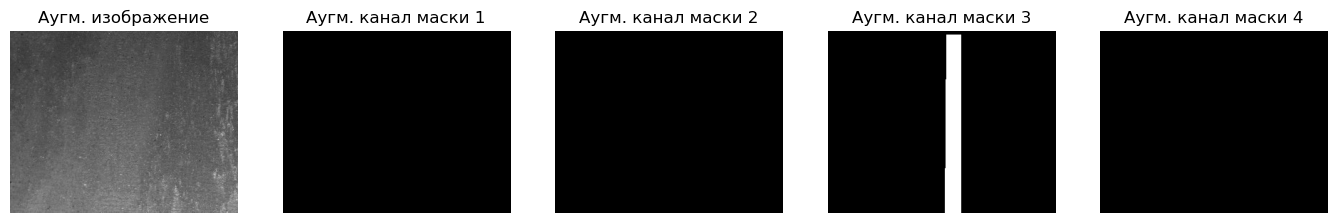

In [20]:
display_image_and_mask(image, mask)

In [21]:
# Нормализуем каждый канал изображения
def get_preprocessing():
    _transform = [
        A.Normalize(mean=(0.485, 0.456, 0.406),
                    std=(0.229, 0.224, 0.225))
    ]
    return A.Compose(_transform)

In [22]:
# Нормализуем изображение и маску
sample = get_preprocessing()(image=image, mask=mask)

image = sample['image']
mask = sample['mask']

In [23]:
# Переведем изображение в тензор, переставим размерность
image_tensor = torch.Tensor(image).permute(2, 0, 1)
image_tensor.shape

torch.Size([3, 256, 320])

In [24]:
# Переведем маску в тензор, переставим размерность
# Cоздадим метки, которые указывают на присутствие классов
# В итоге получим тензор из меток дефекта для каждого класса - tensor([0., 0., 1., 0.])
mask_tensor = torch.Tensor(np.max(mask, axis=(0, 1)))
mask_tensor.shape # torch.Size([4])

torch.Size([4])

In [25]:
# Соберем в класс
class Dataset_train:
    def __init__(
            self,
            ids,
            df,
            images_dir=BASE_DIR,
            dim=IN_DIM,
            augmentation=None,
            preprocessing=None
    ):

        """
        Класс для загрузки обучающего набора данных.

        :param ids: Список имен изображений.
        :param df: DataFrame, с информацией о масках.
        :param images_dir: Директория с изображениями.
        :param dim: Размер входного изображения.
        :param augmentation: Объект аугментации изображения (по умолчанию None).
        :param preprocessing: Объект предварительной обработки изображения (по умолчанию None).
        """

        self.ids = ids
        self.df=df
        self.images_path = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.dim=dim
        self.augmentation = augmentation
        self.preprocessing = preprocessing

    def __getitem__(self, i):
        """
        Возвращает один элемент набора данных.

        :param i: Индекс элемента.
        :return: Кортеж из изображения и маски в формате тензоров.
        """
        # Прочитаем изображение
        image = cv2.imread(self.images_path[i], -1)

        # Построим маску
        mask_df = self.df[self.df['ImageId'] == self.ids[i]]
        rles = mask_df['EncodedPixels'].values
        class_ids = mask_df['ClassId'].values
        mask = build_masks(rles, class_ids, input_shape=self.dim, num_classes=MASK_CHANELS)
        mask = np.asarray(mask, np.uint8)

        # Добавим аугментацию
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        # Добавим препроцессинг
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image = sample['image']
            mask = sample['mask']

        # Возвращаем изображение и информацию о присутствии классов
        return torch.Tensor(image).permute(2, 0, 1), torch.Tensor(np.max(mask, axis=(0,1)))

    def __len__(self):
        """
        Возвращает количество элементов в наборе данных.

        :return: Количество элементов.
        """
        return len(self.ids)

In [26]:
train_dataset = Dataset_train(
        ids=train_files,
        df=train_df,
        augmentation=get_training_augmentation_crop_image(),
        preprocessing=get_preprocessing()
)

In [27]:
train_dataset[12][1]

tensor([0., 0., 0., 0.])

## 4 Датасет для валидационных данных

Еще немного поработаем с изображением и поделим его на 5 участков по ширине

Следующее предположение по разделению каждой валидационной картинки на участки:

- Возможно повышение производительности;
- Учет пространственных особенностей (модель лучше должна работать на участках с меньшим числом пикселей);
- Учет особенности сеток по входному размеру данных.

In [28]:
print(f'Список названий изображений для валидации: {valid_files}')

Список названий изображений для валидации: ['0002cc93b.jpg' '000a4bcdd.jpg' '005da33cf.jpg' ... 'ffb48ee43.jpg'
 'ffe93442c.jpg' 'fffe98443.jpg']


Обработаем маску:

In [29]:
# Определим маску для 15-го индекса
mask_df = train_df[train_df['ImageId'] == valid_files[15]]
rles = mask_df['EncodedPixels'].values
class_ids = mask_df['ClassId'].values

display(mask_df)
print(f'Класс дефекта: {class_ids}')

,ImageId,ClassId,EncodedPixels
38,012f26693.jpg,3,4396 14 4632 42 4878 61 5133 70 5388 76 5643 7...
39,012f26693.jpg,4,35258 2 35513 5 35768 8 36023 11 36277 15 3653...


Класс дефекта: [3 4]


In [30]:
# Массив многослойных масок (в случае с несколькими классами) из списка rle строк
mask = build_masks(rles, class_ids, input_shape=IN_DIM, num_classes=MASK_CHANELS)
mask = np.asarray(mask, np.uint8)

mask.shape

(256, 1600, 4)

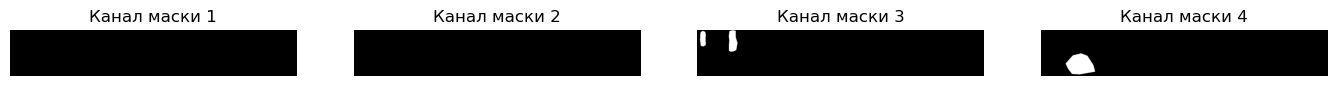

In [31]:
# Отобразим маски
display_masks(mask)

Прочитаем изображение

In [32]:
# Пути до каждого изображения
images_path = [os.path.join(BASE_DIR, image_id) for image_id in valid_files]

In [33]:
# Откроем одно изображение
image = cv2.imread(images_path[15], -1)
image.shape

(256, 1600, 3)

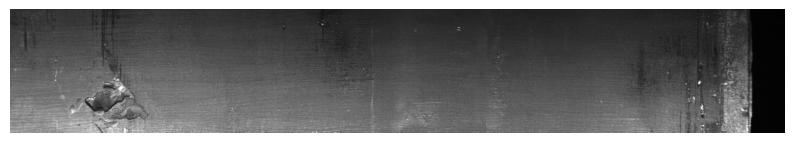

In [34]:
# Отобразим изображение
display_image(image)

In [35]:
# Число участков
N_CROP = 5

# Размер участка
OUT_DIM = (N_CROP, 256, 320)

# Число входных каналов (RGB)
IMG_CHANELS = 3

In [36]:
# Пустые массивы для хранения участков
image_crop = np.empty((*OUT_DIM, IMG_CHANELS))
mask_crop = np.empty((*OUT_DIM, MASK_CHANELS))

image_crop.shape, mask_crop.shape

((5, 256, 320, 3), (5, 256, 320, 4))

In [37]:
# В цикле пройдем по каждому из 5 участков и извлечем обрезок сохранив в _empt
for i in range(N_CROP):
    image_crop[i] = image[:, i * OUT_DIM[2] : (i + 1) * OUT_DIM[2], :]
    mask_crop[i] = mask[:, i * OUT_DIM[2] : (i + 1) * OUT_DIM[2], :]

image_crop.shape, mask_crop.shape

((5, 256, 320, 3), (5, 256, 320, 4))

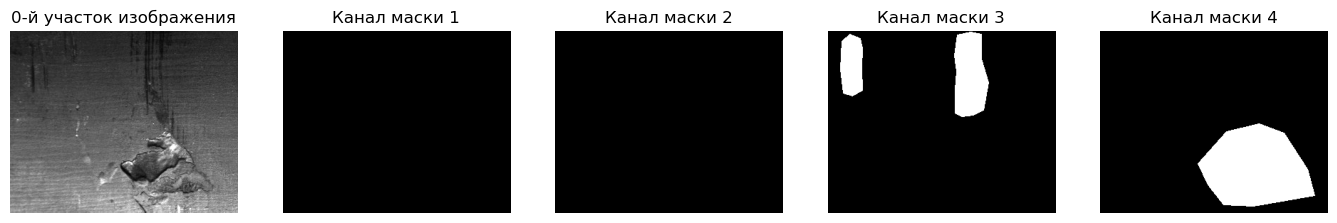

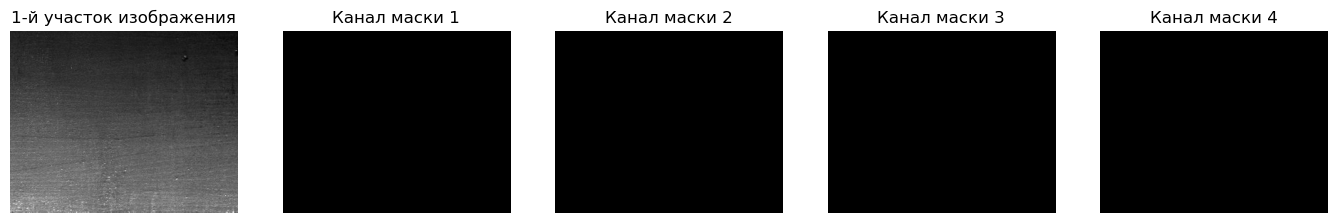

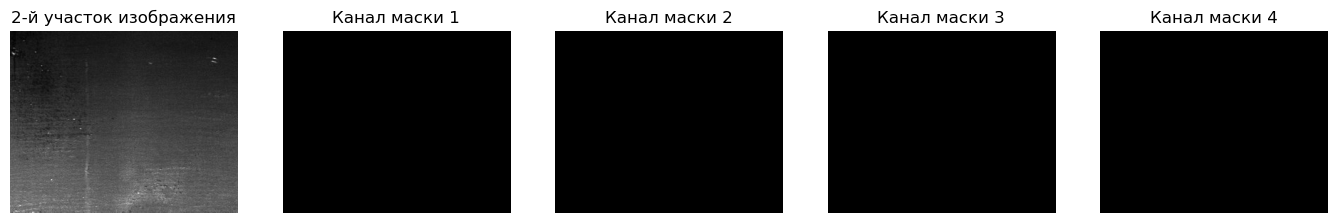

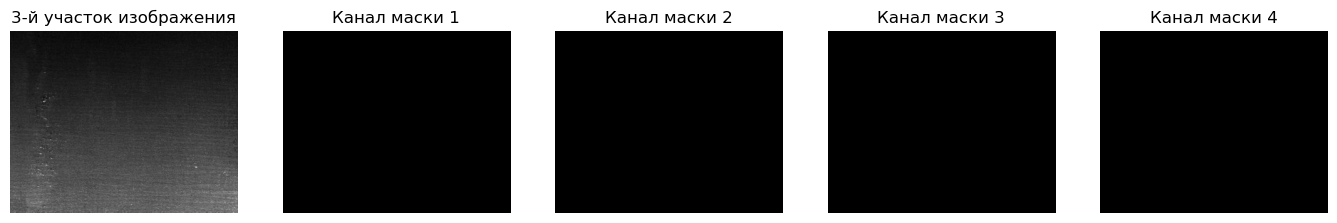

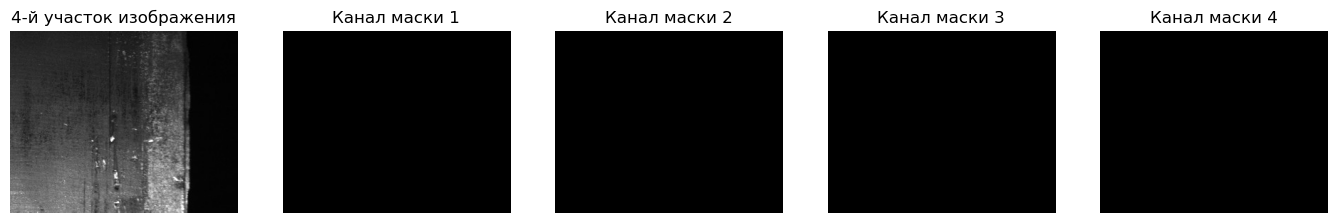

In [38]:
# Отобразим все изображения и все каналы маски
def show_image_and_mask(image, mask, crop):
    fig, axes = plt.subplots(1, MASK_CHANELS + 1, figsize=(17, 5))
    axes[0].imshow(image[:, :, 0], cmap='gray')
    axes[0].set_title(f'{i}-й участок изображения')
    for j in range(MASK_CHANELS):
        axes[j + 1].imshow(mask[:, :, j], cmap='gray')
        axes[j + 1].set_title(f'Канал маски {j + 1}')
        axes[j + 1].axis('off')
    axes[0].axis('off')
    plt.show()

# Отображение всех участков
for i in range(N_CROP):
    show_image_and_mask(image_crop[i], mask_crop[i], i)

In [39]:
# Нормализуем изображение
sample = get_preprocessing()(image=image_crop, mask=mask_crop)
image_crop = sample['image']
mask_crop = sample['mask']

In [40]:
# Переведем изображение в тензор, переставим размерность
image_tensor = torch.Tensor(image_crop).permute(0, 3, 1, 2)
image_tensor.shape

torch.Size([5, 3, 256, 320])

In [41]:
# Переведем маску в тензор, переставим размерность
# Cоздадим метки, которые указывают на присутствие классов
# tensor([[0., 0., 1., 1.],
        # [0., 0., 0., 0.],
        # [0., 0., 0., 0.],
        # [0., 0., 0., 0.],
        # [0., 0., 0., 0.]])
mask_tensor = torch.Tensor(np.max(mask_crop, axis=(1, 2)))
mask_tensor.shape # torch.Size([5, 4])

torch.Size([5, 4])

In [42]:
mask_tensor

tensor([[0., 0., 1., 1.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]])

In [43]:
class Dataset_valid(Dataset):
    def __init__(self,
                 ids,
                 df,
                 images_dir=BASE_DIR,
                 dim=IN_DIM,
                 preprocessing=None):
        """
        Класс для загрузки валидационного набора данных.

        :param ids: Список имен изображений.
        :param df: DataFrame, с информацией о масках.
        :param images_dir: Директория с изображениями.
        :param dim: Размер входного изображения.
        :param preprocessing: Объект предварительной обработки изображения (по умолчанию None).
        """
        self.ids = ids
        self.df = df
        self.images_path = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.dim = dim
        self.preprocessing = preprocessing

    def __getitem__(self, i):
        """
        Возвращает нарезанное изображение и маски на участки.

        Args:
            i (int): Индекс изображения.

        Returns:
            torch.Tensor: Нарезанное изображение на учвастки.
            torch.Tensor: Нарезанная маска на участки с 4-мя слоями на каждом.
        """
        # Чтение данных
        image = cv2.imread(self.images_path[i], -1)

        # Создание маски
        mask_df = self.df[self.df['ImageId'] == self.ids[i]]
        rles = mask_df['EncodedPixels'].values
        class_ids = mask_df['ClassId'].values
        mask = build_masks(rles, class_ids, input_shape=self.dim, num_classes=MASK_CHANELS)

        # Пустые массивы для хранения обрезков
        image_crop = np.empty((*OUT_DIM, IMG_CHANELS))
        mask_crop = np.empty((*OUT_DIM, MASK_CHANELS))

        # Выполнение обрезки
        for i in range(N_CROP):
            image_crop[i] = image[:, i * OUT_DIM[2] : (i + 1) * OUT_DIM[2], :]
            mask_crop[i] = mask[:, i * OUT_DIM[2] : (i + 1) * OUT_DIM[2], :]

        # Применение препроцессинга
        if self.preprocessing:
            sample = self.preprocessing(image=image_crop, mask=mask_crop)
            image_crop, mask_crop = sample['image'], sample['mask']

        # Преобразование в тензоры
        image_crop = torch.Tensor(image_crop).permute(0, 3, 1, 2)
        mask_crop = torch.Tensor(np.max(mask_crop, axis=(1, 2)))

        return image_crop, mask_crop

    def __len__(self):
        """
        Возвращает количество изображений в датасете.

        Returns:
            int: Количество изображений.
        """
        return len(self.ids)

In [44]:
valid_dataset = Dataset_valid(
    ids=valid_files,
    df=train_df,
    preprocessing=get_preprocessing()
)

In [45]:
valid_dataset[15][1]

tensor([[0., 0., 1., 1.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]])

## 5 Даталоадер

In [46]:
BATCH_SIZE = 16

In [47]:
dataloaders = {'train': torch.utils.data.DataLoader(train_dataset,
                                                    shuffle=True,
                                                    num_workers=0,
                                                    batch_size=BATCH_SIZE,
                                                    pin_memory=True),
               'val': torch.utils.data.DataLoader(valid_dataset,
                                                  shuffle=False,
                                                  num_workers=0,
                                                  batch_size=1,
                                                  pin_memory=True)}

In [48]:
%%time
next(iter(dataloaders['train']))[1]

CPU times: total: 62.5 ms
Wall time: 366 ms


tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [1., 1., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 1., 0.],
        [1., 0., 0., 0.],
        [0., 0., 0., 0.]])

In [49]:
%%time
next(iter(dataloaders['val']))[1][0]

CPU times: total: 15.6 ms
Wall time: 25.8 ms


tensor([[1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]])

In [50]:
# Размер тренировочного и валидационного датасета
dataset_sizes = {'train': len(train_dataset), 'val': len(valid_dataset)*5}

dataset_sizes

{'train': 10054, 'val': 12570}

## 6 Модель

In [51]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.effnet = torch.hub.load('rwightman/gen-efficientnet-pytorch', 'efficientnet_b0', pretrained=True)
        self.effnet.fc = torch.nn.Sequential()
        self.bn0 = torch.nn.BatchNorm1d(num_features=1000)
        self.fc1 = torch.nn.Linear(1000, 512)
        self.act1 = torch.nn.ReLU()
        self.bn1 = torch.nn.BatchNorm1d(num_features=512)
        self.fc2 = torch.nn.Linear(512, 4)
        self.act2 = torch.nn.Sigmoid()
        
    
    def forward(self, x):
        x = self.effnet(x)
        x = self.bn0(x)
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.act2(x)
        
        return x

In [52]:
model = Net()
model = model.to(device)

Using cache found in C:\Users\Admin/.cache\torch\hub\rwightman_gen-efficientnet-pytorch_master


## 7 Метрики

In [53]:
# Считаем основные метрики для каждой маски класса
def get_metrics(true, pred):
    val_f1, val_precision, val_recall, val_acc = [], [], [], []
    for i in range(4):
        val_f1.append(round(f1_score(true[:,i], pred[:,i], zero_division=0), 3))
        val_precision.append(round(precision_score(true[:,i], pred[:,i], zero_division=0), 3))
        val_recall.append(round(recall_score(true[:,i], pred[:,i], zero_division=0), 3))
        val_acc.append(round(accuracy_score(true[:,i], pred[:,i]), 3))

    val_f1_mean = np.mean(val_f1)

    print('f1_mean: {:.3f}, \nf1: {}, \npresicion: {}, \nrecall: {}, \nacc: {}'.format(
          val_f1_mean, val_f1, val_precision, val_recall, val_acc), end=' ')
    return val_f1_mean

## 8 Обучение

Прогоним один батч обучения в первой эпохе. Проверим ожидаемые размерности и работоспособность модели.

Тренировка

In [54]:
# Шаг обучения
LR = 4e-4

# Коэф уменьшения шага обучения. Работает по условию уменьшения шага обучения
REDUCE_LR_FACTOR = 0.25

# Число эпох без улучшения целевой метрики
REDUCE_LR_PATIENCE = 7

# Минимальный шаг обучения.
REDUCE_LR_MIN = 1e-6

# ФП для бинарной классификации
criterion = torch.nn.BCELoss(reduction='none')

# Оптимизатор
optimizer_ft = torch.optim.Adam(model.parameters(), lr=LR)

# Шедуллер
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_ft, mode='max', # Максимизируем f1
                                                                  factor=REDUCE_LR_FACTOR,
                                                                  patience=REDUCE_LR_PATIENCE,
                                                                  min_lr=REDUCE_LR_MIN
                                                                    )

In [55]:
# Глубокая копия весов модели
best_model_wts = copy.deepcopy(model.state_dict())

# Переведем модель в режим обучения (для bn и droput)
model.train()
running_loss = 0.0

In [56]:
# Возьмем один демонстрационный батч
for inputs, labels in dataloaders['train']:
    inputs = inputs.to(device)
    labels = labels.to(device)
    break

inputs.shape, labels.shape

(torch.Size([16, 3, 256, 320]), torch.Size([16, 4]))

In [57]:
# Посмотрим на маски классов
labels

tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 0.],
        [0., 0., 1., 0.],
        [1., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]], device='cuda:0')

In [58]:
# Обнулим градиенты
optimizer_ft.zero_grad()

In [59]:
# Выполняем прогноз модели
# Включаем режим отслеживания градиентов для последующего бэкпропа
with torch.set_grad_enabled(True):
    outputs = model(inputs)
    print(outputs)
    print(outputs.shape)

tensor([[0.4098, 0.5830, 0.3538, 0.5981],
        [0.3880, 0.4875, 0.3891, 0.6264],
        [0.3654, 0.3373, 0.4530, 0.5552],
        [0.3496, 0.7236, 0.6072, 0.5115],
        [0.4292, 0.3061, 0.4183, 0.6146],
        [0.3108, 0.5672, 0.4770, 0.5450],
        [0.4154, 0.5564, 0.4424, 0.5710],
        [0.4012, 0.2315, 0.4425, 0.6177],
        [0.2292, 0.5136, 0.4409, 0.5952],
        [0.2456, 0.4152, 0.4495, 0.6576],
        [0.2759, 0.3986, 0.2256, 0.4736],
        [0.3049, 0.3561, 0.5359, 0.6817],
        [0.3687, 0.4156, 0.4221, 0.5373],
        [0.2852, 0.4821, 0.5384, 0.5732],
        [0.2600, 0.4384, 0.6629, 0.5832],
        [0.5304, 0.3543, 0.3387, 0.5867]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
torch.Size([16, 4])


In [60]:
# Бинаризируем с порогом 0.5
preds = (outputs > 0.5).long()
print(preds)
print(preds.shape)

tensor([[0, 1, 0, 1],
        [0, 0, 0, 1],
        [0, 0, 0, 1],
        [0, 1, 1, 1],
        [0, 0, 0, 1],
        [0, 1, 0, 1],
        [0, 1, 0, 1],
        [0, 0, 0, 1],
        [0, 1, 0, 1],
        [0, 0, 0, 1],
        [0, 0, 0, 0],
        [0, 0, 1, 1],
        [0, 0, 0, 1],
        [0, 0, 1, 1],
        [0, 0, 1, 1],
        [1, 0, 0, 1]], device='cuda:0')
torch.Size([16, 4])


In [61]:
outputs, labels

(tensor([[0.4098, 0.5830, 0.3538, 0.5981],
         [0.3880, 0.4875, 0.3891, 0.6264],
         [0.3654, 0.3373, 0.4530, 0.5552],
         [0.3496, 0.7236, 0.6072, 0.5115],
         [0.4292, 0.3061, 0.4183, 0.6146],
         [0.3108, 0.5672, 0.4770, 0.5450],
         [0.4154, 0.5564, 0.4424, 0.5710],
         [0.4012, 0.2315, 0.4425, 0.6177],
         [0.2292, 0.5136, 0.4409, 0.5952],
         [0.2456, 0.4152, 0.4495, 0.6576],
         [0.2759, 0.3986, 0.2256, 0.4736],
         [0.3049, 0.3561, 0.5359, 0.6817],
         [0.3687, 0.4156, 0.4221, 0.5373],
         [0.2852, 0.4821, 0.5384, 0.5732],
         [0.2600, 0.4384, 0.6629, 0.5832],
         [0.5304, 0.3543, 0.3387, 0.5867]], device='cuda:0',
        grad_fn=<SigmoidBackward0>),
 tensor([[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 1., 0.],
         [0., 0., 1., 0.],
         [0., 0., 0., 0.],
         [0., 0., 1., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 1., 0.],
         [0., 

In [62]:
# Проверим размерность
outputs.shape, labels.shape

(torch.Size([16, 4]), torch.Size([16, 4]))

In [63]:
# Вычислим среднюю потерю BCELoss по батчу без усреднения см. доку
# https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html
loss = criterion(outputs, labels)
print(loss)

tensor([[0.5273, 0.8747, 0.4367, 0.9115],
        [0.4910, 0.6684, 0.4928, 0.9847],
        [0.4547, 0.4114, 0.7918, 0.8102],
        [0.4302, 1.2860, 0.4988, 0.7164],
        [0.5607, 0.3655, 0.5417, 0.9536],
        [0.3723, 0.8375, 0.7401, 0.7874],
        [0.5369, 0.8128, 0.5840, 0.8463],
        [0.5128, 0.2634, 0.5844, 0.9614],
        [0.2603, 0.7207, 0.8189, 0.9042],
        [0.2819, 0.5366, 0.7997, 1.0719],
        [0.3228, 0.5085, 0.2557, 0.6417],
        [0.3637, 0.4402, 0.6239, 1.1448],
        [0.9979, 0.5372, 0.5483, 0.7707],
        [0.3358, 0.6580, 0.7730, 0.8515],
        [0.3011, 0.5770, 1.0874, 0.8751],
        [0.7559, 0.4374, 0.4135, 0.8835]], device='cuda:0',
       grad_fn=<BinaryCrossEntropyBackward0>)


In [64]:
# Усредняем потери по классам для каждого изображения
mean_losses_per_image = loss.mean(dim=1)
mean_losses_per_image

tensor([0.6875, 0.6592, 0.6170, 0.7329, 0.6054, 0.6843, 0.6950, 0.5805, 0.6761,
        0.6725, 0.4321, 0.6432, 0.7135, 0.6546, 0.7102, 0.6226],
       device='cuda:0', grad_fn=<MeanBackward1>)

In [65]:
# Усредняем по всем изображениям в батче
mean_loss = mean_losses_per_image.mean()
mean_loss

tensor(0.6492, device='cuda:0', grad_fn=<MeanBackward0>)

In [66]:
# Вычислим градиенты ф. п. ко всем параметрам модели (backprop)
mean_loss.backward()

# Обновим параметры модели на основе вычисленных градиентов
optimizer_ft.step()

In [67]:
inputs.size()

torch.Size([16, 3, 256, 320])

In [68]:
# Вычислим общую потерю батча и добавим к потерям всех батчей
running_loss += mean_loss.item() * inputs.size(0)
running_loss

10.38646125793457

In [69]:
# Размер датасета
dataset_sizes

{'train': 10054, 'val': 12570}

In [70]:
# Средняя потеря на один объект (изображение)
# Когда накопится ошибка по всем батчам
epoch_loss_train = running_loss / dataset_sizes['train']
epoch_loss_train

0.00103306756096425

Валидация

In [71]:
# Режим валидации
model.eval()

running_loss = 0.0

In [72]:
pred, true = [], []

In [73]:
# Батч из одного элемена для валидации
for inputs, labels in dataloaders['val']:
    inputs = inputs[0].to(device)
    labels = labels[0].to(device)
    break

In [74]:
# Посмотрим на размерность
inputs.shape, labels.shape

(torch.Size([5, 3, 256, 320]), torch.Size([5, 4]))

In [75]:
# Паосмотрим на маски каждого класса в разрезе участков
labels

tensor([[1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]], device='cuda:0')

In [76]:
# Вычилим прогнозы для участка и его каждого класса без подсчета градиента
with torch.no_grad():
    outputs = model(inputs)

print(outputs)
print(outputs.shape)

tensor([[0.3785, 0.3976, 0.7229, 0.4928],
        [0.3194, 0.3625, 0.6444, 0.5175],
        [0.3676, 0.3924, 0.5635, 0.5089],
        [0.3484, 0.3703, 0.5370, 0.5844],
        [0.3475, 0.4426, 0.5178, 0.5109]], device='cuda:0')
torch.Size([5, 4])


In [77]:
# Бинаризируем порог по границе 0.5
preds = (outputs > 0.5).long()
print(preds)

tensor([[0, 0, 1, 0],
        [0, 0, 1, 1],
        [0, 0, 1, 1],
        [0, 0, 1, 1],
        [0, 0, 1, 1]], device='cuda:0')


In [78]:
# Вычислим среднюю потерю BCELoss по батчу (по 5 участкам изображения)
loss = criterion(outputs, labels)
print(loss)

tensor([[0.9716, 0.5068, 1.2833, 0.6789],
        [1.1414, 0.4501, 1.0339, 0.7287],
        [1.0007, 0.4983, 0.8290, 0.7111],
        [0.4284, 0.4625, 0.7700, 0.8780],
        [0.4269, 0.5845, 0.7295, 0.7152]], device='cuda:0')


In [79]:
# Усредняем потери по классам для каждого участка изображения
mean_losses_per_image = loss.mean(dim=1)
mean_losses_per_image

tensor([0.8601, 0.8385, 0.7598, 0.6347, 0.6140], device='cuda:0')

In [80]:
# Усредняем по всем изображениям в батче (одного целого изображения)
mean_loss = mean_losses_per_image.mean()
mean_loss

tensor(0.7414, device='cuda:0')

In [81]:
# Вычислим общую потерю батча и добавим к потерям всех батчей
running_loss += mean_loss.item() * inputs.size(0)
print(running_loss)

3.707231879234314


In [82]:
# Сохраним предсказания и истинные метки в список
# Перенесем на cpu
true.extend(labels.data.cpu().numpy())
pred.extend(preds.data.cpu().numpy())
true, pred

([array([1., 0., 0., 0.], dtype=float32),
  array([1., 0., 0., 0.], dtype=float32),
  array([1., 0., 0., 0.], dtype=float32),
  array([0., 0., 0., 0.], dtype=float32),
  array([0., 0., 0., 0.], dtype=float32)],
 [array([0, 0, 1, 0], dtype=int64),
  array([0, 0, 1, 1], dtype=int64),
  array([0, 0, 1, 1], dtype=int64),
  array([0, 0, 1, 1], dtype=int64),
  array([0, 0, 1, 1], dtype=int64)])

In [83]:
print(dataset_sizes)

# Средняя потеря на один объект (изображение)
# Когда накопится running_loss по всем изображениям
epoch_loss_val = running_loss / dataset_sizes['val']
epoch_loss_val

{'train': 10054, 'val': 12570}


0.00029492695936629386

In [84]:
# Сравним потери на одно изображение для трейна и валидации
print('train loss: {:.4f} val loss: {:.4f}'.format(epoch_loss_train, epoch_loss_val))

train loss: 0.0010 val loss: 0.0003


In [85]:
# Выведем предсказания и действительные метки
pred = np.array(pred)
true = np.array(true)

print(f'true: \n{true}, \npred: \n{pred}')

true: 
[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]], 
pred: 
[[0 0 1 0]
 [0 0 1 1]
 [0 0 1 1]
 [0 0 1 1]
 [0 0 1 1]]


In [86]:
# Посчитаем основные метрики
metrics_val = get_metrics(true, pred)
metrics_val

f1_mean: 0.000, 
f1: [0.0, 0.0, 0.0, 0.0], 
presicion: [0.0, 0.0, 0.0, 0.0], 
recall: [0.0, 0.0, 0.0, 0.0], 
acc: [0.4, 1.0, 0.0, 0.2] 

0.0

### 8.1 Класс обучения

In [59]:
def train_model(model, criterion, optimizer, dataloaders, dataset_sizes,
                scheduler, device, num_epochs=25, early_stop_patience=15):
    # Временная отметка
    since = time.time()

    # Глубокая копия весов модели
    best_model_wts = copy.deepcopy(model.state_dict())

    # Переменная лучшей метрики
    best_metrics = 0.0

    # Счетчик ранней остановки
    early_stoping = 0

    for epoch in tqdm(range(num_epochs)):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Переведем модель в режим обучения
        model.train()
        running_loss = 0.0

        # Обучение
        # Число батчей для обучения
        num_batches_to_process_test = dataloaders['train'].__len__()
        
        for i, (inputs, labels) in enumerate(dataloaders['train']):
            if i >= num_batches_to_process_test:
                break
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Обнулим градиенты
            optimizer.zero_grad()

            # Режим отслеживания градиентов для последующего бэкпропа
            with torch.set_grad_enabled(True):
                outputs = model(inputs)

                # Бинаризируем по порогу 0.5
                preds = (outputs > 0.5).long()

                # Вычислим среднюю потерю BCELoss по батчу без усреднения см. доку
                # https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html
                loss = criterion(outputs, labels)

                # Усредняем потери классов для каждого изображения
                mean_losses_per_image = loss.mean(dim=1)

                # Усредняем по всем изображениям в батче
                mean_loss = mean_losses_per_image.mean()

                # Вычислим градиенты ф. п. ко всем параметрам модели (backprop)
                mean_loss.backward()

                # Обновим параметры модели на основе вычисленных градиентов
                optimizer.step()

            # Вычислим общую потерю батча и добавим к потерям всех батчей
            running_loss += mean_loss.item() * inputs.size(0)

        # Средняя потеря на один объект (изображение)
        epoch_loss_train = running_loss / dataset_sizes['train']

        # Валидация
        model.eval()

        running_loss = 0.0

        pred, true = [], []

        # Число батчей для валидации
        num_batches_to_process_val = dataloaders['val'].__len__()
        
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            if i >= num_batches_to_process_val:
                break
            inputs = inputs[0].to(device)
            labels = labels[0].to(device)

            # Прогнозы для участка и его каждого класса без подсчета градиента
            with torch.no_grad():
                outputs = model(inputs)

                # Бинаризируем порог по границе 0.5
                preds = (outputs > 0.5).long()

                # Вычислим среднюю потерю BCELoss по батчу без усреднения
                loss = criterion(outputs, labels)

                # Усредняем потери классов для каждого участка изображения
                mean_losses_per_image = loss.mean(dim=1)

                # Усредняем по всем изображениям в батче (одного целого изображения)
                mean_loss = mean_losses_per_image.mean()

            # Вычислим общую потерю батча и добавим к потерям всех батчей
            running_loss += mean_loss.item() * inputs.size(0)

            # Сохраним предсказания и истинные метки в список
            true.extend(labels.data.cpu().numpy())
            pred.extend(preds.data.cpu().numpy())

        # Средняя потеря на один объект (изображение)
        epoch_loss_val = running_loss / dataset_sizes['val']

        # Выведем потери на одно изображение для трейна и валидации
        print('train loss: {:.4f} val loss: {:.4f}'.format(epoch_loss_train, epoch_loss_val))

        # Предсказания и действительные метки
        pred = np.array(pred)
        true = np.array(true)

        # Посчитаем основные метрики
        metrics_val = get_metrics(true, pred)

        # Будем сохранять каждую эпоху веса модели если метрика лучше предыдущей
        if metrics_val > best_metrics:
            print('*')
            best_metrics = metrics_val # Смотрим по f1

            # Делаем глубокое копирование словаря с парметрами модели
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(best_model_wts, PATH_WEIGTS)
            early_stoping = 0
        else:
            print('-')
            # Если модель не улучшает скор на эпохе то знач. счетчика += 1
            early_stoping += 1

        # Условие ранней остановки
        if early_stoping > early_stop_patience:
            break

        # Шаг шедуллера для отслеживания метрики см. EARLY_STOP_PATIENCE
        scheduler.step(metrics_val)

        # Запишем логи
        with open('./weights_and_logs/logs_3weigthted.txt','a') as f:
            f.write('''train_loss: {:.4f} val_loss: {:.4f} val_metrics: {:.4f}\n'''.format(epoch_loss_train,
                                                                                           epoch_loss_val,
                                                                                           metrics_val))
    # Подсчитаем время выполнения
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val metrics: {:4f}'.format(best_metrics))

    # Загрузим веса лучшей модели
    model.load_state_dict(best_model_wts)
    return model

## 9 Параметры обучения

In [60]:
# Путь логов для сохранения модели
file_weigts_name = '2-stage-mclass-model3-weighted_fold_%d.h5'%NUM_FOLD
PATH_WEIGTS = os.path.join(os.path.join(os.path.dirname(notebook_path), 'weights_and_logs'),  file_weigts_name)


# Определим основные параметры обучения
LR = 4e-4
REDUCE_LR_FACTOR = 0.25
REDUCE_LR_PATIENCE = 7
REDUCE_LR_MIN = 1e-6

# Поскольку у нас значительный дисбаланс классов, используем weighted loss
num_samples = sum([897, 247, 5150, 801]) # Число дефектов каждого класса
class_weights = torch.tensor([num_samples / 897,
                              num_samples / 247,
                              num_samples / 5150,
                              num_samples / 801]).to(device)

criterion = torch.nn.BCELoss(weight=class_weights, reduction='none')
optimizer_ft = torch.optim.Adam(model.parameters(), lr=LR)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_ft, mode='max',
                                                                  factor=REDUCE_LR_FACTOR,
                                                                  patience=REDUCE_LR_PATIENCE,
                                                                  min_lr=REDUCE_LR_MIN
                                                                    )

## 10 Запуск обучения

In [61]:
EPOCHS = 100
EARLY_STOP_PATIENCE = 15

model = train_model(model, criterion, optimizer_ft, dataloaders,
                        dataset_sizes, lr_scheduler, device,
                        num_epochs=EPOCHS, early_stop_patience=EARLY_STOP_PATIENCE)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 0/99
----------


  1%|          | 1/100 [03:59<6:35:41, 239.82s/it]

train loss: 0.9996 val loss: 0.5240
f1_mean: 0.436, 
f1: [0.021, 0.304, 0.761, 0.657], 
presicion: [0.75, 0.21, 0.827, 0.932], 
recall: [0.01, 0.553, 0.705, 0.508], 
acc: [0.977, 0.991, 0.919, 0.984] *
Epoch 1/99
----------


  2%|▏         | 2/100 [07:53<6:25:20, 235.92s/it]

train loss: 0.6074 val loss: 0.3800
f1_mean: 0.669, 
f1: [0.622, 0.511, 0.77, 0.774], 
presicion: [0.627, 0.383, 0.823, 0.916], 
recall: [0.618, 0.766, 0.724, 0.67], 
acc: [0.983, 0.995, 0.921, 0.988] *
Epoch 2/99
----------


  3%|▎         | 3/100 [11:46<6:19:54, 234.99s/it]

train loss: 0.5747 val loss: 0.3799
f1_mean: 0.606, 
f1: [0.667, 0.259, 0.74, 0.757], 
presicion: [0.693, 1.0, 0.857, 0.907], 
recall: [0.642, 0.149, 0.652, 0.649], 
acc: [0.985, 0.997, 0.916, 0.988] -
Epoch 3/99
----------


  4%|▍         | 4/100 [15:39<6:14:37, 234.14s/it]

train loss: 0.5914 val loss: 0.3961
f1_mean: 0.537, 
f1: [0.631, 0.0, 0.777, 0.739], 
presicion: [0.538, 0.0, 0.757, 0.773], 
recall: [0.764, 0.0, 0.798, 0.707], 
acc: [0.98, 0.996, 0.916, 0.985] -
Epoch 4/99
----------


  5%|▌         | 5/100 [19:33<6:10:18, 233.88s/it]

train loss: 0.5248 val loss: 0.3285
f1_mean: 0.716, 
f1: [0.661, 0.654, 0.77, 0.777], 
presicion: [0.574, 0.596, 0.832, 0.923], 
recall: [0.778, 0.723, 0.717, 0.67], 
acc: [0.982, 0.997, 0.921, 0.988] *
Epoch 5/99
----------


  6%|▌         | 6/100 [23:26<6:05:59, 233.61s/it]

train loss: 0.5201 val loss: 0.4762
f1_mean: 0.644, 
f1: [0.602, 0.533, 0.771, 0.668], 
presicion: [0.479, 0.409, 0.769, 0.946], 
recall: [0.809, 0.766, 0.773, 0.516], 
acc: [0.975, 0.995, 0.916, 0.985] -
Epoch 6/99
----------


  7%|▋         | 7/100 [27:19<6:01:56, 233.52s/it]

train loss: 0.4827 val loss: 0.3487
f1_mean: 0.673, 
f1: [0.586, 0.508, 0.779, 0.819], 
presicion: [0.887, 0.405, 0.829, 0.891], 
recall: [0.438, 0.681, 0.735, 0.758], 
acc: [0.986, 0.995, 0.923, 0.99] -
Epoch 7/99
----------


  8%|▊         | 8/100 [31:13<5:58:12, 233.61s/it]

train loss: 0.4363 val loss: 0.3674
f1_mean: 0.696, 
f1: [0.71, 0.488, 0.809, 0.777], 
presicion: [0.647, 0.345, 0.847, 0.887], 
recall: [0.788, 0.83, 0.775, 0.691], 
acc: [0.985, 0.993, 0.933, 0.988] -
Epoch 8/99
----------


  9%|▉         | 9/100 [35:06<5:53:59, 233.40s/it]

train loss: 0.4380 val loss: 0.3136
f1_mean: 0.728, 
f1: [0.71, 0.645, 0.796, 0.762], 
presicion: [0.727, 0.652, 0.809, 0.833], 
recall: [0.694, 0.638, 0.784, 0.702], 
acc: [0.987, 0.997, 0.926, 0.987] *
Epoch 9/99
----------


 10%|█         | 10/100 [38:59<5:49:49, 233.22s/it]

train loss: 0.4263 val loss: 0.3593
f1_mean: 0.705, 
f1: [0.714, 0.561, 0.797, 0.749], 
presicion: [0.638, 0.435, 0.899, 0.659], 
recall: [0.809, 0.787, 0.716, 0.867], 
acc: [0.985, 0.995, 0.933, 0.983] -
Epoch 10/99
----------


 11%|█         | 11/100 [42:52<5:45:58, 233.24s/it]

train loss: 0.3985 val loss: 0.3101
f1_mean: 0.734, 
f1: [0.765, 0.513, 0.819, 0.837], 
presicion: [0.868, 0.367, 0.782, 0.826], 
recall: [0.684, 0.851, 0.86, 0.848], 
acc: [0.99, 0.994, 0.93, 0.99] *
Epoch 11/99
----------


 12%|█▏        | 12/100 [46:45<5:42:11, 233.32s/it]

train loss: 0.3536 val loss: 0.3298
f1_mean: 0.717, 
f1: [0.669, 0.565, 0.818, 0.815], 
presicion: [0.631, 0.429, 0.835, 0.798], 
recall: [0.712, 0.83, 0.802, 0.832], 
acc: [0.984, 0.995, 0.934, 0.989] -
Epoch 12/99
----------


 13%|█▎        | 13/100 [50:39<5:38:18, 233.31s/it]

train loss: 0.3866 val loss: 0.2784
f1_mean: 0.780, 
f1: [0.796, 0.727, 0.834, 0.761], 
presicion: [0.793, 0.692, 0.82, 0.938], 
recall: [0.799, 0.766, 0.849, 0.641], 
acc: [0.991, 0.998, 0.938, 0.988] *
Epoch 13/99
----------


 14%|█▍        | 14/100 [54:31<5:34:10, 233.14s/it]

train loss: 0.3670 val loss: 0.2618
f1_mean: 0.793, 
f1: [0.755, 0.758, 0.83, 0.831], 
presicion: [0.786, 0.75, 0.816, 0.901], 
recall: [0.726, 0.766, 0.846, 0.771], 
acc: [0.989, 0.998, 0.937, 0.991] *
Epoch 14/99
----------


 15%|█▌        | 15/100 [58:24<5:30:13, 233.10s/it]

train loss: 0.3868 val loss: 0.2896
f1_mean: 0.758, 
f1: [0.754, 0.661, 0.806, 0.81], 
presicion: [0.758, 0.549, 0.851, 0.876], 
recall: [0.75, 0.83, 0.766, 0.753], 
acc: [0.989, 0.997, 0.932, 0.989] -
Epoch 15/99
----------


 16%|█▌        | 16/100 [1:02:17<5:26:07, 232.95s/it]

train loss: 0.3714 val loss: 0.2788
f1_mean: 0.773, 
f1: [0.786, 0.674, 0.824, 0.809], 
presicion: [0.809, 0.744, 0.815, 0.889], 
recall: [0.764, 0.617, 0.833, 0.742], 
acc: [0.99, 0.998, 0.935, 0.989] -
Epoch 16/99
----------


 17%|█▋        | 17/100 [1:06:10<5:22:16, 232.97s/it]

train loss: 0.3354 val loss: 0.2651
f1_mean: 0.750, 
f1: [0.705, 0.692, 0.822, 0.782], 
presicion: [0.917, 0.871, 0.826, 0.934], 
recall: [0.573, 0.574, 0.818, 0.673], 
acc: [0.989, 0.998, 0.935, 0.989] -
Epoch 17/99
----------


 18%|█▊        | 18/100 [1:10:03<5:18:24, 232.98s/it]

train loss: 0.3334 val loss: 0.2856
f1_mean: 0.749, 
f1: [0.764, 0.681, 0.825, 0.727], 
presicion: [0.764, 0.681, 0.828, 0.961], 
recall: [0.764, 0.681, 0.823, 0.585], 
acc: [0.989, 0.998, 0.936, 0.987] -
Epoch 18/99
----------


 19%|█▉        | 19/100 [1:13:56<5:14:29, 232.96s/it]

train loss: 0.3308 val loss: 0.2773
f1_mean: 0.766, 
f1: [0.716, 0.69, 0.829, 0.829], 
presicion: [0.69, 0.58, 0.837, 0.895], 
recall: [0.743, 0.851, 0.821, 0.771], 
acc: [0.986, 0.997, 0.938, 0.99] -
Epoch 19/99
----------


 20%|██        | 20/100 [1:17:49<5:10:43, 233.05s/it]

train loss: 0.3484 val loss: 0.2886
f1_mean: 0.742, 
f1: [0.685, 0.629, 0.811, 0.843], 
presicion: [0.577, 0.667, 0.855, 0.881], 
recall: [0.844, 0.596, 0.772, 0.809], 
acc: [0.982, 0.997, 0.934, 0.991] -
Epoch 20/99
----------


 21%|██        | 21/100 [1:21:42<5:06:53, 233.08s/it]

train loss: 0.3243 val loss: 0.2575
f1_mean: 0.781, 
f1: [0.801, 0.71, 0.819, 0.794], 
presicion: [0.773, 0.717, 0.864, 0.913], 
recall: [0.83, 0.702, 0.778, 0.702], 
acc: [0.991, 0.998, 0.937, 0.989] -
Epoch 21/99
----------


 22%|██▏       | 22/100 [1:25:35<5:03:00, 233.08s/it]

train loss: 0.2712 val loss: 0.2612
f1_mean: 0.766, 
f1: [0.804, 0.615, 0.829, 0.814], 
presicion: [0.867, 0.482, 0.879, 0.837], 
recall: [0.75, 0.851, 0.785, 0.793], 
acc: [0.992, 0.996, 0.941, 0.989] -
Epoch 22/99
----------


 23%|██▎       | 23/100 [1:29:28<4:58:58, 232.96s/it]

train loss: 0.2552 val loss: 0.2245
f1_mean: 0.790, 
f1: [0.836, 0.645, 0.843, 0.836], 
presicion: [0.878, 0.519, 0.878, 0.899], 
recall: [0.799, 0.851, 0.81, 0.782], 
acc: [0.993, 0.996, 0.944, 0.991] -
Epoch 23/99
----------


 24%|██▍       | 24/100 [1:33:21<4:55:12, 233.05s/it]

train loss: 0.2366 val loss: 0.2018
f1_mean: 0.829, 
f1: [0.828, 0.796, 0.844, 0.847], 
presicion: [0.813, 0.804, 0.862, 0.856], 
recall: [0.844, 0.787, 0.828, 0.838], 
acc: [0.992, 0.998, 0.944, 0.991] *
Epoch 24/99
----------


 25%|██▌       | 25/100 [1:37:14<4:51:04, 232.86s/it]

train loss: 0.2202 val loss: 0.2123
f1_mean: 0.818, 
f1: [0.812, 0.755, 0.851, 0.853], 
presicion: [0.774, 0.725, 0.864, 0.881], 
recall: [0.854, 0.787, 0.839, 0.827], 
acc: [0.991, 0.998, 0.946, 0.991] -
Epoch 25/99
----------


 26%|██▌       | 26/100 [1:41:07<4:47:15, 232.92s/it]

train loss: 0.2175 val loss: 0.2225
f1_mean: 0.799, 
f1: [0.813, 0.684, 0.849, 0.851], 
presicion: [0.797, 0.571, 0.855, 0.894], 
recall: [0.83, 0.851, 0.844, 0.811], 
acc: [0.991, 0.997, 0.945, 0.991] -
Epoch 26/99
----------


 27%|██▋       | 27/100 [1:44:59<4:43:14, 232.81s/it]

train loss: 0.2172 val loss: 0.1987
f1_mean: 0.828, 
f1: [0.807, 0.796, 0.851, 0.858], 
presicion: [0.776, 0.804, 0.876, 0.851], 
recall: [0.84, 0.787, 0.828, 0.864], 
acc: [0.991, 0.998, 0.947, 0.991] -
Epoch 27/99
----------


 28%|██▊       | 28/100 [1:48:52<4:39:23, 232.82s/it]

train loss: 0.2098 val loss: 0.1996
f1_mean: 0.827, 
f1: [0.828, 0.783, 0.847, 0.848], 
presicion: [0.837, 0.8, 0.88, 0.865], 
recall: [0.819, 0.766, 0.817, 0.832], 
acc: [0.992, 0.998, 0.946, 0.991] -
Epoch 28/99
----------


 29%|██▉       | 29/100 [1:52:45<4:35:33, 232.86s/it]

train loss: 0.2095 val loss: 0.2009
f1_mean: 0.827, 
f1: [0.811, 0.791, 0.851, 0.856], 
presicion: [0.775, 0.818, 0.868, 0.9], 
recall: [0.851, 0.766, 0.836, 0.816], 
acc: [0.991, 0.998, 0.946, 0.992] -
Epoch 29/99
----------


 30%|███       | 30/100 [1:56:38<4:31:36, 232.81s/it]

train loss: 0.2049 val loss: 0.2006
f1_mean: 0.827, 
f1: [0.822, 0.784, 0.847, 0.853], 
presicion: [0.783, 0.76, 0.88, 0.89], 
recall: [0.865, 0.809, 0.816, 0.819], 
acc: [0.991, 0.998, 0.946, 0.992] -
Epoch 30/99
----------


 31%|███       | 31/100 [2:00:31<4:27:53, 232.95s/it]

train loss: 0.1972 val loss: 0.2126
f1_mean: 0.810, 
f1: [0.84, 0.763, 0.851, 0.787], 
presicion: [0.831, 0.74, 0.892, 0.912], 
recall: [0.851, 0.787, 0.812, 0.691], 
acc: [0.993, 0.998, 0.948, 0.989] -
Epoch 31/99
----------


 32%|███▏      | 32/100 [2:04:25<4:24:10, 233.10s/it]

train loss: 0.1674 val loss: 0.2094
f1_mean: 0.822, 
f1: [0.839, 0.779, 0.855, 0.814], 
presicion: [0.821, 0.771, 0.851, 0.941], 
recall: [0.858, 0.787, 0.859, 0.718], 
acc: [0.992, 0.998, 0.947, 0.99] -
Epoch 32/99
----------


 33%|███▎      | 33/100 [2:08:18<4:20:27, 233.25s/it]

train loss: 0.1763 val loss: 0.1970
f1_mean: 0.828, 
f1: [0.829, 0.779, 0.854, 0.848], 
presicion: [0.853, 0.771, 0.882, 0.901], 
recall: [0.806, 0.787, 0.828, 0.801], 
acc: [0.992, 0.998, 0.948, 0.991] -
Epoch 33/99
----------


 34%|███▍      | 34/100 [2:12:11<4:16:28, 233.16s/it]

train loss: 0.1657 val loss: 0.2037
f1_mean: 0.835, 
f1: [0.835, 0.8, 0.856, 0.849], 
presicion: [0.804, 0.792, 0.858, 0.904], 
recall: [0.868, 0.809, 0.854, 0.801], 
acc: [0.992, 0.998, 0.947, 0.991] *
Epoch 34/99
----------


 35%|███▌      | 35/100 [2:16:05<4:12:37, 233.20s/it]

train loss: 0.1772 val loss: 0.2014
f1_mean: 0.831, 
f1: [0.836, 0.779, 0.854, 0.857], 
presicion: [0.813, 0.771, 0.867, 0.915], 
recall: [0.861, 0.787, 0.842, 0.806], 
acc: [0.992, 0.998, 0.947, 0.992] -
Epoch 35/99
----------


 36%|███▌      | 36/100 [2:19:57<4:08:36, 233.07s/it]

train loss: 0.1462 val loss: 0.1980
f1_mean: 0.834, 
f1: [0.833, 0.795, 0.854, 0.852], 
presicion: [0.797, 0.854, 0.86, 0.895], 
recall: [0.872, 0.745, 0.848, 0.814], 
acc: [0.992, 0.999, 0.947, 0.992] -
Epoch 36/99
----------


 37%|███▋      | 37/100 [2:23:51<4:04:46, 233.12s/it]

train loss: 0.1542 val loss: 0.1958
f1_mean: 0.842, 
f1: [0.837, 0.822, 0.854, 0.855], 
presicion: [0.82, 0.86, 0.832, 0.9], 
recall: [0.854, 0.787, 0.877, 0.814], 
acc: [0.992, 0.999, 0.945, 0.992] *
Epoch 37/99
----------


 38%|███▊      | 38/100 [2:27:43<4:00:50, 233.08s/it]

train loss: 0.1650 val loss: 0.2001
f1_mean: 0.833, 
f1: [0.813, 0.804, 0.855, 0.859], 
presicion: [0.759, 0.822, 0.874, 0.869], 
recall: [0.875, 0.787, 0.838, 0.848], 
acc: [0.991, 0.999, 0.948, 0.992] -
Epoch 38/99
----------


 39%|███▉      | 39/100 [2:31:37<3:57:03, 233.18s/it]

train loss: 0.1630 val loss: 0.1939
f1_mean: 0.834, 
f1: [0.839, 0.787, 0.855, 0.856], 
presicion: [0.818, 0.833, 0.87, 0.92], 
recall: [0.861, 0.745, 0.841, 0.801], 
acc: [0.992, 0.998, 0.948, 0.992] -
Epoch 39/99
----------


 40%|████      | 40/100 [2:35:30<3:53:06, 233.11s/it]

train loss: 0.1627 val loss: 0.1914
f1_mean: 0.839, 
f1: [0.847, 0.787, 0.855, 0.866], 
presicion: [0.828, 0.833, 0.88, 0.882], 
recall: [0.868, 0.745, 0.832, 0.851], 
acc: [0.993, 0.998, 0.948, 0.992] -
Epoch 40/99
----------


 41%|████      | 41/100 [2:39:23<3:49:10, 233.06s/it]

train loss: 0.1514 val loss: 0.1916
f1_mean: 0.837, 
f1: [0.84, 0.791, 0.858, 0.861], 
presicion: [0.814, 0.818, 0.878, 0.904], 
recall: [0.868, 0.766, 0.839, 0.822], 
acc: [0.992, 0.998, 0.949, 0.992] -
Epoch 41/99
----------


 42%|████▏     | 42/100 [2:43:16<3:45:11, 232.96s/it]

train loss: 0.1527 val loss: 0.1895
f1_mean: 0.838, 
f1: [0.832, 0.8, 0.86, 0.861], 
presicion: [0.828, 0.837, 0.878, 0.901], 
recall: [0.837, 0.766, 0.842, 0.824], 
acc: [0.992, 0.999, 0.949, 0.992] -
Epoch 42/99
----------


 43%|████▎     | 43/100 [2:47:09<3:41:24, 233.06s/it]

train loss: 0.1620 val loss: 0.2023
f1_mean: 0.832, 
f1: [0.824, 0.787, 0.856, 0.86], 
presicion: [0.778, 0.787, 0.864, 0.872], 
recall: [0.875, 0.787, 0.849, 0.848], 
acc: [0.991, 0.998, 0.948, 0.992] -
Epoch 43/99
----------


 44%|████▍     | 44/100 [2:51:02<3:37:31, 233.07s/it]

train loss: 0.1564 val loss: 0.1958
f1_mean: 0.841, 
f1: [0.841, 0.809, 0.858, 0.856], 
presicion: [0.804, 0.809, 0.868, 0.877], 
recall: [0.882, 0.809, 0.848, 0.835], 
acc: [0.992, 0.999, 0.948, 0.992] -
Epoch 44/99
----------


 45%|████▌     | 45/100 [2:54:55<3:33:45, 233.18s/it]

train loss: 0.1454 val loss: 0.1929
f1_mean: 0.847, 
f1: [0.843, 0.817, 0.857, 0.869], 
presicion: [0.804, 0.826, 0.883, 0.88], 
recall: [0.885, 0.809, 0.834, 0.859], 
acc: [0.992, 0.999, 0.949, 0.992] *
Epoch 45/99
----------


 46%|████▌     | 46/100 [2:58:49<3:29:59, 233.32s/it]

train loss: 0.1683 val loss: 0.1997
f1_mean: 0.834, 
f1: [0.833, 0.791, 0.857, 0.854], 
presicion: [0.789, 0.818, 0.859, 0.844], 
recall: [0.882, 0.766, 0.856, 0.864], 
acc: [0.992, 0.998, 0.948, 0.991] -
Epoch 46/99
----------


 47%|████▋     | 47/100 [3:02:43<3:26:13, 233.46s/it]

train loss: 0.1476 val loss: 0.1904
f1_mean: 0.845, 
f1: [0.86, 0.8, 0.854, 0.865], 
presicion: [0.856, 0.837, 0.846, 0.904], 
recall: [0.865, 0.766, 0.863, 0.83], 
acc: [0.994, 0.999, 0.946, 0.992] -
Epoch 47/99
----------


 48%|████▊     | 48/100 [3:06:36<3:22:19, 233.45s/it]

train loss: 0.1581 val loss: 0.1855
f1_mean: 0.842, 
f1: [0.847, 0.791, 0.857, 0.873], 
presicion: [0.837, 0.818, 0.879, 0.91], 
recall: [0.858, 0.766, 0.837, 0.838], 
acc: [0.993, 0.998, 0.949, 0.993] -
Epoch 48/99
----------


 49%|████▉     | 49/100 [3:10:30<3:18:28, 233.49s/it]

train loss: 0.1485 val loss: 0.1955
f1_mean: 0.841, 
f1: [0.845, 0.8, 0.856, 0.864], 
presicion: [0.847, 0.792, 0.862, 0.914], 
recall: [0.844, 0.809, 0.851, 0.819], 
acc: [0.993, 0.998, 0.947, 0.992] -
Epoch 49/99
----------


 50%|█████     | 50/100 [3:14:23<3:14:33, 233.47s/it]

train loss: 0.1463 val loss: 0.1903
f1_mean: 0.842, 
f1: [0.855, 0.8, 0.852, 0.86], 
presicion: [0.849, 0.837, 0.885, 0.88], 
recall: [0.861, 0.766, 0.821, 0.84], 
acc: [0.993, 0.999, 0.948, 0.992] -
Epoch 50/99
----------


 51%|█████     | 51/100 [3:18:16<3:10:29, 233.26s/it]

train loss: 0.1659 val loss: 0.1934
f1_mean: 0.837, 
f1: [0.839, 0.791, 0.858, 0.86], 
presicion: [0.81, 0.818, 0.877, 0.861], 
recall: [0.872, 0.766, 0.839, 0.859], 
acc: [0.992, 0.998, 0.949, 0.992] -
Epoch 51/99
----------


 52%|█████▏    | 52/100 [3:22:09<3:06:36, 233.26s/it]

train loss: 0.1429 val loss: 0.1927
f1_mean: 0.838, 
f1: [0.844, 0.791, 0.855, 0.863], 
presicion: [0.832, 0.818, 0.877, 0.89], 
recall: [0.858, 0.766, 0.834, 0.838], 
acc: [0.993, 0.998, 0.948, 0.992] -
Epoch 52/99
----------


 53%|█████▎    | 53/100 [3:26:03<3:02:46, 233.34s/it]

train loss: 0.1439 val loss: 0.1957
f1_mean: 0.831, 
f1: [0.844, 0.758, 0.858, 0.862], 
presicion: [0.825, 0.75, 0.865, 0.914], 
recall: [0.865, 0.766, 0.851, 0.816], 
acc: [0.993, 0.998, 0.948, 0.992] -
Epoch 53/99
----------


 54%|█████▍    | 54/100 [3:29:56<2:58:47, 233.20s/it]

train loss: 0.1407 val loss: 0.1940
f1_mean: 0.840, 
f1: [0.838, 0.791, 0.858, 0.872], 
presicion: [0.801, 0.818, 0.859, 0.901], 
recall: [0.878, 0.766, 0.857, 0.846], 
acc: [0.992, 0.998, 0.948, 0.993] -
Epoch 54/99
----------


 55%|█████▌    | 55/100 [3:33:49<2:54:51, 233.14s/it]

train loss: 0.1456 val loss: 0.1943
f1_mean: 0.842, 
f1: [0.845, 0.8, 0.856, 0.867], 
presicion: [0.812, 0.837, 0.865, 0.893], 
recall: [0.882, 0.766, 0.848, 0.843], 
acc: [0.993, 0.999, 0.948, 0.992] -
Epoch 55/99
----------


 56%|█████▌    | 56/100 [3:37:41<2:50:51, 232.98s/it]

train loss: 0.1557 val loss: 0.1925
f1_mean: 0.840, 
f1: [0.844, 0.791, 0.856, 0.867], 
presicion: [0.816, 0.818, 0.837, 0.895], 
recall: [0.875, 0.766, 0.875, 0.84], 
acc: [0.993, 0.998, 0.946, 0.992] -
Epoch 56/99
----------


 57%|█████▋    | 57/100 [3:41:33<2:46:45, 232.68s/it]

train loss: 0.1504 val loss: 0.1881
f1_mean: 0.845, 
f1: [0.856, 0.791, 0.858, 0.873], 
presicion: [0.837, 0.818, 0.87, 0.908], 
recall: [0.875, 0.766, 0.846, 0.84], 
acc: [0.993, 0.998, 0.948, 0.993] -
Epoch 57/99
----------


 58%|█████▊    | 58/100 [3:45:26<2:42:54, 232.73s/it]

train loss: 0.1378 val loss: 0.1904
f1_mean: 0.843, 
f1: [0.848, 0.8, 0.853, 0.871], 
presicion: [0.833, 0.837, 0.88, 0.903], 
recall: [0.865, 0.766, 0.828, 0.84], 
acc: [0.993, 0.999, 0.948, 0.993] -
Epoch 58/99
----------


 59%|█████▉    | 59/100 [3:49:19<2:39:07, 232.88s/it]

train loss: 0.1432 val loss: 0.1921
f1_mean: 0.844, 
f1: [0.849, 0.8, 0.857, 0.868], 
presicion: [0.828, 0.837, 0.881, 0.898], 
recall: [0.872, 0.766, 0.834, 0.84], 
acc: [0.993, 0.999, 0.949, 0.992] -
Epoch 59/99
----------


 60%|██████    | 60/100 [3:53:12<2:35:11, 232.80s/it]

train loss: 0.1209 val loss: 0.1878
f1_mean: 0.844, 
f1: [0.858, 0.795, 0.857, 0.866], 
presicion: [0.845, 0.854, 0.872, 0.902], 
recall: [0.872, 0.745, 0.841, 0.832], 
acc: [0.993, 0.999, 0.948, 0.992] -
Epoch 60/99
----------


 60%|██████    | 60/100 [3:57:05<2:38:03, 237.08s/it]

train loss: 0.1449 val loss: 0.1910
f1_mean: 0.841, 
f1: [0.843, 0.791, 0.858, 0.871], 
presicion: [0.804, 0.818, 0.852, 0.891], 
recall: [0.885, 0.766, 0.864, 0.851], 
acc: [0.992, 0.998, 0.947, 0.992] -
Training complete in 237m 5s
Best val metrics: 0.846500


## 11 Результаты

In [6]:
with open(os.path.join(os.path.join(os.path.dirname(notebook_path), 'weights_and_logs'), 
                       '2-stage-mclass-logs3-weigthted.txt'),'r') as f:
    logs = f.read()

logs = logs.split('\n')

metrics_4 = [float(x.split(' ')[-1]) for x in logs[:-1]]
train_loss_4 = [float(x.split(' ')[1]) for x in logs[:-1]]
val_loss_4 = [float(x.split(' ')[3]) for x in logs[:-1]]

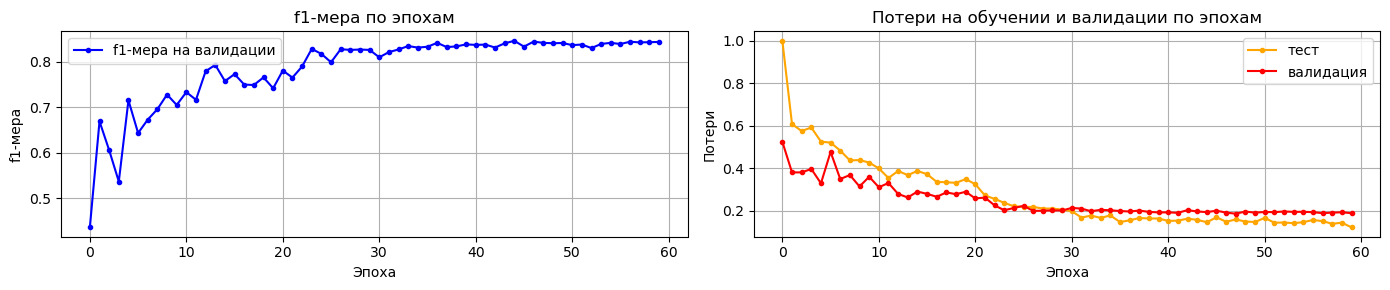

In [12]:
# Визуализация потерь и f1-мера
plt.figure(figsize=(14, 3))

# График f1 - метрики
plt.subplot(1, 2, 1)
plt.plot(metrics_4, '.-', label='f1-мера на валидации', color='blue')
plt.xlabel('Эпоха')
plt.ylabel('f1-мера')
plt.title('f1-мера по эпохам')
plt.legend()
plt.grid(True)

# График потерь
plt.subplot(1, 2, 2)
plt.plot(train_loss_4, '.-', label='тест', color='orange')
plt.plot(val_loss_4, '.-', label='валидация', color='red')
plt.xlabel('Эпоха')
plt.ylabel('Потери')
plt.title('Потери на обучении и валидации по эпохам')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

__Модель: `efficientnet_b0`/ f1 среднее по четырем классам на валидации 45 эпохи: `0.847`. Модель предсказывала наличие или отсутствия четырех классов дефектов на изображении.__


```
train loss: 0.1454 val loss: 0.1929
f1_mean: 0.847, 
f1: [0.843, 0.817, 0.857, 0.869], 
presicion: [0.804, 0.826, 0.883, 0.88], 
recall: [0.885, 0.809, 0.834, 0.859], 
acc: [0.992, 0.999, 0.949, 0.992] *
Epoch 45/99
```

class_weights = [ 7.9097, 28.7247,  1.3777,  8.8577]

EPOCHS = 100

EARLY_STOP_PATIENCE = 15

BCELoss(weight=class_weights, reduction='none'),

Adam(4e-4),

ReduceLROnPlateau(REDUCE_LR_FACTOR = 0.25, REDUCE_LR_PATIENCE = 7, REDUCE_LR_MIN = 1e-6)

**Интерпретация результатов:**

- Средний F1-скор (f1_mean: 0.847): Не плохое значение, учитывая сбалансированную точность и полноту для всех классов.

- F1-меры для каждого класса:

```
Класс 1: 0.843
Класс 2: 0.817
Класс 3: 0.857
Класс 4: 0.869

- ~Попробовать: ResNet, EfficientNet-B7, ResNet + Attention (CBAM), ViT и ансамблирование.~